In [2]:
# Example of Tool Functionalities using some fake generated cell data

In [3]:
# 1. Import

import sys
sys.path.append('../') # Necessary to access classes functions from other folder

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv as cv
import classes.data_prep as prep
import classes.gp as gp
import classes.data_visualisation as visualisation
import classes.optimisation as optimisation
import classes.model_selection as model_selection
from matplotlib.backends.backend_pdf import PdfPages

import warnings # Necessary to avoid certain common warnings from coming up. Won't affect inference.
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

 Excel File Path : /Users/erikangravina/Documents/GitHub/Gene-Expression-Data-Analysis-with-Gaussian-Process/data/Hes1 Promoter 2014.xlsx
 Excel File Path : /Users/erikangravina/Documents/GitHub/Gene-Expression-Data-Analysis-with-Gaussian-Process/data/Control Promoter.xlsx
Length of observations 83 for cell 1
Length of observations 140 for cell 2
Length of observations 97 for cell 3
Length of observations 140 for cell 4
Length of observations 93 for cell 5
Length of observations 94 for cell 6
Length of observations 82 for cell 7
Length of observations 92 for cell 8
Length of observations 56 for cell 9
Length of observations 52 for cell 10
Length of observations 80 for cell 11
Length of observations 75 for cell 12
Length of observations 54 for cell 13
Length of observations 74 for cell 14
Length of observations 63 for cell 15
Length of observations 77 for cell 16
Length of observations 77 for cell 17
Length of observations 73 for cell 18
Length of observations 49 for cell 19
Length of o

(-3, 4)

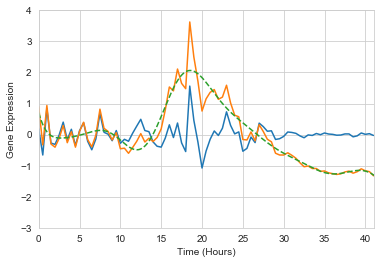

In [6]:
# 2. Import Data from Excel and Prep it

# Collecting real data from an excel spreadsheet is made easy thanks to the gel_excel() function in the data_prep class.
# Similary, to prep the collected data we need to convert time to hours, normalise the data and detrend it.
# The choice of the detrending parameter is 

df = prep.Data_Input().get_excel()
df_control = prep.Data_Input().get_excel()
number_of_observed_cells = 19
number_of_control_cells = 25

# Check no NaNs are present/remove if so, then store in list.

observed_cells = prep.Data_Input().remove_nans(number_of_observed_cells, df)
control_cells = prep.Data_Input().remove_nans(number_of_control_cells, df_control)

# Time in Hours

time = df.iloc[:,0]
time = time.to_numpy()[2:len(time)]     #Store Time into a numpy array. #todo: change 2 to 1 when formatting convention has been finalised.
time = time/(60*60*1000)

# Normalisation

normalised_cells = prep.Normalisation().normalise_many_cells_from_list(observed_cells)
normalised_control_cells = prep.Normalisation().normalise_many_cells_from_list(control_cells)

# Detrending

detrending_parameter = np.exp(-4.5)
detrended_data = prep.Detrending(alpha = detrending_parameter).detrend_data_from_list(time, normalised_cells)
detrended_control_data = prep.Detrending(alpha = detrending_parameter).detrend_data_from_list(time, normalised_control_cells)[0]

# - - Plot of one Detrended Traces against the Original Normalised Signal

trendfit_x = detrended_data[1]
trendfit_y_cell = detrended_data[2][0]
detrended_cell = detrended_data[0][0]
detrended_data = detrended_data[0]

Fig = plt.figure("Detrended Data")
plt.xlabel("Time (Hours)")
plt.ylabel("Gene Expression")
plt.plot(time[0:len(detrended_cell)], detrended_cell)
plt.plot(time[0:len(detrended_cell)], normalised_cells[0])
plt.plot(trendfit_x, trendfit_y_cell, ls = '--')
plt.xlim(0, time[0:len(detrended_cell)][-1])
plt.ylim(-3, 4)

#/data/Hes1 Promoter 2014.xlsx
#/data/Control Promoter.xlsx

Completed Fitting of 15 Observed Cells
Completed Generation of Synthetic Cells for all 15  Observed Cell
Completed Fitting of OUosc and OU GP on Synthetic, Storing Results and Calculating LLR from Observed Cell 1
Completed Fitting of OUosc and OU GP on Synthetic, Storing Results and Calculating LLR from Observed Cell 2
Completed Fitting of OUosc and OU GP on Synthetic, Storing Results and Calculating LLR from Observed Cell 3
Completed Fitting of OUosc and OU GP on Synthetic, Storing Results and Calculating LLR from Observed Cell 4
Completed Fitting of OUosc and OU GP on Synthetic, Storing Results and Calculating LLR from Observed Cell 5
Completed Fitting of OUosc and OU GP on Synthetic, Storing Results and Calculating LLR from Observed Cell 6
Completed Fitting of OUosc and OU GP on Synthetic, Storing Results and Calculating LLR from Observed Cell 7
Completed Fitting of OUosc and OU GP on Synthetic, Storing Results and Calculating LLR from Observed Cell 8
Completed Fitting of OUosc and 

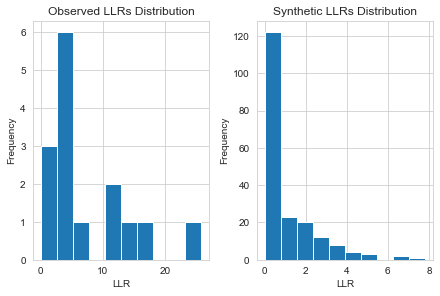

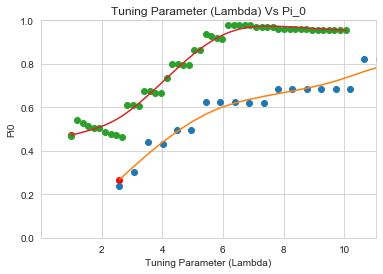

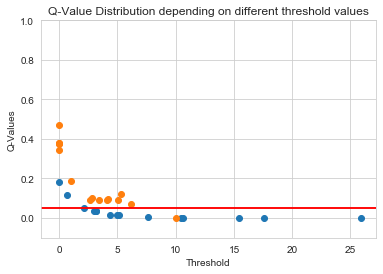

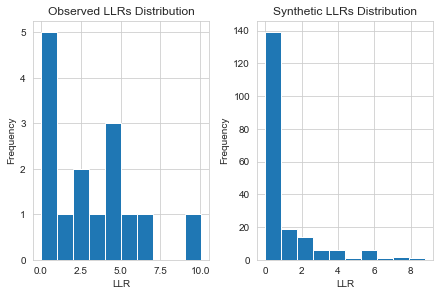

In [10]:
# Model Selection Process for all observed and control cells

# This model selection relies on the bootstrap approximation of the distribution of LLRs for a population of non-oscillating cells.
# This is then used as a frame of reference to compare our observed LLR distributions to identify both visually and analytically whether
# our sample of observed cells are behaving in an oscillatory or non-oscillatory manner. Analytically the estimation of q-values is used.
# For more information on the Model Selection process in detail I recommend checking out the documentation.

# Warning: model selection is currently the most expensive in terms of running time.

modelselection = model_selection.ModelSelection()
modelselection_obs = modelselection.model_selection_for_list_new(observed_timepoints = time, observed_cells = detrended_data, number_of_synthetic_cells = 2000, control_q_value = 0.05, initial_guess = [0.001, 0.5, 0.5, 0.5])
modelselection_control = modelselection.model_selection_for_list_new(observed_timepoints = time, observed_cells = detrended_control_data, number_of_synthetic_cells = 2000, control_q_value = 0.05, initial_guess = [0.001, 0.5, 0.5, 0.5])

In [15]:
# 6. Extracting Results from Model Selection Process

# From the model selection function you may access results such as:
# - LLRs (both from the observed group, control group and synthetic group)
# - Estimated parameters for the fitting of both the oscillatory and non-oscillatory model to the observed group.
# - Q Values estimated from the model selection process, which includes a 'passlist' which is
#   1 for a significant q_value (deemed oscillatory) and 0 if not.
#   

# 1. LLRs 

LLRs_observed = modelselection_obs[0][0]
LLRs_control = modelselection_control[0][0]
LLRs_synthetic = np.vstack((modelselection_obs[0][1], modelselection_control[0][1]))

#print(" - - - - - - - - - - ")
#print("LLRs - Observed Cell")
#print(prep.Data_Export().export_LLRs_estimates(modelselection_obs[0]))
#print("LLRs - Control Cell")
#print(prep.Data_Export().export_LLRs_estimates(modelselection_control[0]))

# 2. Estimated Parameters 

parameters_observed = modelselection_obs[1]
parameters_control = modelselection_control[1]

print(" - - - - - - - - - - ")
print("Estimated Parameters - Observed Cell")
print(prep.Data_Export().export_parameter_estimates(parameters_observed))
print(" - - - - - - - - - - ")
print("Estimated Parameters - Control Cell")
print(prep.Data_Export().export_parameter_estimates(parameters_control))

# Period Analysis

print(" - - - - - - - - - - ")
print(prep.Data_Export().period_estimation(parameters_observed))

# 3. Q-Values -> True Positives, False Positives, True Negatives and False Negatives

q_values_observed = modelselection_obs[2]
q_values_control = modelselection_control[2]

contingency_table = modelselection.contingency_table(q_values_observed, q_values_control)

print(" - - - - - - - - - - ")
print("TP, FP, TN, FN")
print(prep.Data_Export().export_contingency_table(contingency_table))

 - - - - - - - - - - 
Estimated Parameters - Observed Cell
                   Cell1         Cell2         Cell3         Cell4  \
OUosc alpha     0.126189  3.826534e-01  5.411558e-01  8.123644e-01   
OUosc beta      0.392854  5.287418e-01  6.595395e-01  2.105904e-03   
OUosc variance  0.219858  4.703582e-01  5.339960e-01  6.409191e-01   
OUosc noise     0.328663  2.483594e-08  4.588417e-07  1.000000e-10   
OU alpha        0.441603  4.626436e-01  6.910986e-01  8.123728e-01   
OU variance     0.272818  4.645550e-01  5.156189e-01  6.409210e-01   
OU noise        0.251937  1.000000e-10  2.237819e-06  1.000000e-10   

                       Cell5         Cell6     Cell7         Cell8  \
OUosc alpha     5.089399e-01  1.569148e-01  0.244594  3.811276e-01   
OUosc beta      5.289409e-01  3.710353e-01  1.110680  5.198435e-01   
OUosc variance  2.430875e-01  1.028735e+00  0.217492  5.433405e-01   
OUosc noise     1.337771e-01  1.988843e-01  0.341003  1.000000e-10   
OU alpha        7.436515e-01  